<a href="https://colab.research.google.com/github/dhanmoti/ml-exercise/blob/smu-fnce685-project/SMU_FNCE685_G2_PD_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
# Install necessary libraries (uncomment in Google Colab)
# !pip install xgboost catboost imbalanced-learn

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE


In [148]:

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/dhanmoti/ml-exercise/main/credit_risk_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [149]:
# drop Null values
# TODO: ask wether to drop all null or create some values
df = df.dropna()

# Check for missing data
missing_values = df.isnull()
missing_values

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,False,False,False,False,False,False,False,False,False,False,False,False
32577,False,False,False,False,False,False,False,False,False,False,False,False
32578,False,False,False,False,False,False,False,False,False,False,False,False
32579,False,False,False,False,False,False,False,False,False,False,False,False


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


# Feature Engineering
## Reasoning:

Feature engineering enhances your dataset by creating new, potentially informative features. These new features help machine learning models capture relationships that aren't obvious with the original features, potentially leading to improved predictive power. However, it's essential to experiment and carefully evaluate the impact of these new features on your model's performance to avoid introducing redundant or irrelevant information. Let me know if you would like to implement some of the features or you have other feature engineering ideas in mind.

## Sources
* www.kaggle.com/learn/feature-engineering
* domino.ai/data-science-dictionary/feature-engineering
* builtin.com/articles/feature-engineering

## 1. Create New Features

* Debt-to-Income Ratio (DTI): Calculate the ratio of the total debt to the person's income. This provides insight into the borrower's financial burden. This could potentially help in identifying riskier candidates.
* Loan-to-Income Ratio (LTI): Calculate the ratio of the loan amount to the person's income, a measure of loan affordability. This could give valuable insights into the risk associated with lending to individuals with different income and loan amount characteristics.
* Combined Loan Purpose: Create a new feature by combining 'loan_intent' and 'loan_grade' to capture a more nuanced view of the loan purpose and risk. This combines information from two existing features, which can potentially reveal a more complex relationship with the target variable.

In [151]:
# Feature Engineering
# TODO: ask Prof and discuss with team which features to engineer?

df['dti'] = df['loan_amnt'] / df['person_income']  # Debt-to-Income Ratio
df['lti'] = df['loan_amnt'] / df['person_income']  # Loan-to-Income Ratio

# Combined Loan Purpose (example - adjust based on your specific logic)
df['combined_loan_purpose'] = df['loan_intent'].astype(str) + '_' + df['loan_grade'].astype(str)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
 12  dti                         28638 non-null  float64
 13  lti                         28638 no

## 2. Binning or Discretization

* Income Bins: Group income into categories (e.g., low, medium, high). This can help capture non-linear relationships with the target variable. Some models perform better with categorical data, and this helps group income into ranges that might have a different impact on risk.
* Loan Amount Bins: Group loan amounts into categories (e.g., small, medium, large). Similar to income bins, this can reveal non-linear patterns. This might be useful if the loan size has varying influence on the likelihood of default.
* Credit History: Convert 'cb_person_default_on_file' into a binary feature. This simplifies the feature. Many models better utilize features with a finite number of distinct values.

In [152]:
# Binning/Discretization
df['income_bin'] = pd.qcut(df['person_income'], q=4, labels=['low', 'medium', 'high', 'very high'])  # Example with 4 bins
df['loan_amnt_bin'] = pd.qcut(df['loan_amnt'], q=3, labels=['small', 'medium', 'large'])  # Example with 3 bins
# df['credit_history_binary'] = df['cb_person_default_on_file'].map({1: 1, 0: 0})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  28638 non-null  int64   
 1   person_income               28638 non-null  int64   
 2   person_home_ownership       28638 non-null  object  
 3   person_emp_length           28638 non-null  float64 
 4   loan_intent                 28638 non-null  object  
 5   loan_grade                  28638 non-null  object  
 6   loan_amnt                   28638 non-null  int64   
 7   loan_int_rate               28638 non-null  float64 
 8   loan_status                 28638 non-null  int64   
 9   loan_percent_income         28638 non-null  float64 
 10  cb_person_default_on_file   28638 non-null  object  
 11  cb_person_cred_hist_length  28638 non-null  int64   
 12  dti                         28638 non-null  float64 
 13  lti                  

## 3. Interactions

Interaction Terms: Create new features by multiplying or dividing existing ones (e.g., DTI * loan_grade). Explore interactions that might improve the model. This helps capture more complex dependencies and could potentially improve the predictive power of the model.

In [153]:
# Interactions (example)
# df['dti_loan_grade_interaction'] = df['dti'] * df['loan_grade']

## 4. Time-Based Features (if applicable)

Loan Age: If you have a loan origination date, calculate the loan age. This could be a factor in risk. Loan risk might increase or decrease over time, and this captures that behavior.
Time Since Last Default: If you have a default date, calculate the time since. This adds valuable information. Loan risk could significantly decrease after a certain amount of time has passed since a past default.

In [134]:
# Time-Based Features (assuming you have loan origination or default dates)
# df['loan_age'] = (pd.to_datetime('today') - pd.to_datetime(df['loan_origination_date'])).dt.days
# df['time_since_default'] = (pd.to_datetime('today') - pd.to_datetime(df['last_default_date'])).dt.days

## 5. Polynomial Features (if applicable)

Polynomial Transformations: Consider creating polynomial features (e.g., income^2) for variables with potential non-linear relationships. This can introduce more complex curves in the model, which might better represent the underlying data distribution.

In [135]:
# Polynomial Features (example for income)
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=2, include_bias=False)
# income_poly = poly.fit_transform(df[['person_income']])
# income_poly_df = pd.DataFrame(income_poly, columns=['person_income', 'person_income_squared'])
# df = pd.concat([df, income_poly_df], axis=1)

# df.info()

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  28638 non-null  int64   
 1   person_income               28638 non-null  int64   
 2   person_home_ownership       28638 non-null  object  
 3   person_emp_length           28638 non-null  float64 
 4   loan_intent                 28638 non-null  object  
 5   loan_grade                  28638 non-null  object  
 6   loan_amnt                   28638 non-null  int64   
 7   loan_int_rate               28638 non-null  float64 
 8   loan_status                 28638 non-null  int64   
 9   loan_percent_income         28638 non-null  float64 
 10  cb_person_default_on_file   28638 non-null  object  
 11  cb_person_cred_hist_length  28638 non-null  int64   
 12  dti                         28638 non-null  float64 
 13  lti                  

In [155]:
# drop Null values
df = df.dropna()

# Check for missing data
missing_values = df.isnull()
missing_values

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,dti,lti,combined_loan_purpose,income_bin,loan_amnt_bin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32577,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32578,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32579,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [158]:
# Encode categorical variables
# TODO: ask which encoding to use one-hot or label
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'income_bin', 'cb_person_default_on_file', 'loan_amnt_bin','combined_loan_purpose']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  int64  
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  int64  
 5   loan_grade                  28638 non-null  int64  
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  int64  
 11  cb_person_cred_hist_length  28638 non-null  int64  
 12  dti                         28638 non-null  float64
 13  lti                         28638 no

# Correlation Matrix

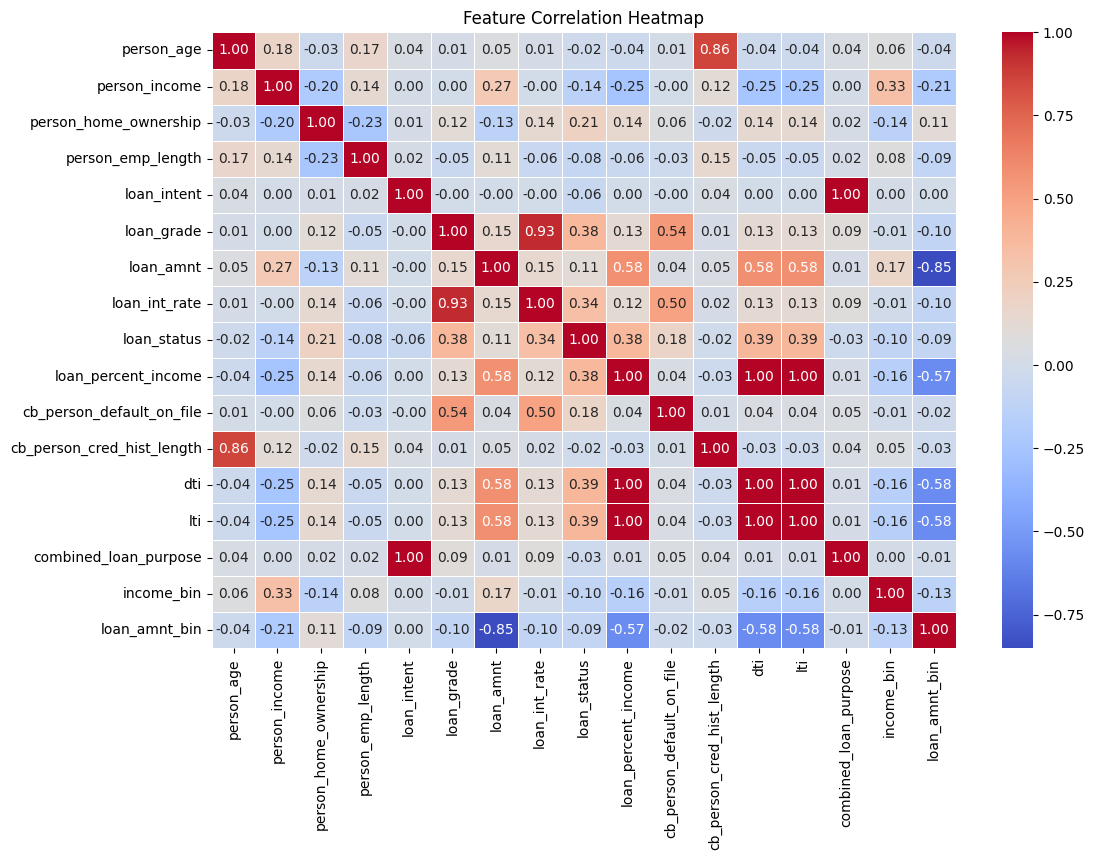

({'cb_person_cred_hist_length',
  'combined_loan_purpose',
  'dti',
  'loan_amnt_bin',
  'loan_int_rate',
  'lti'},
 [])

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Identify highly correlated features (threshold > 0.75)
high_corr_features = set()
corr_threshold = 0.75

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            high_corr_features.add(corr_matrix.columns[i])

# Identify low-variance features
low_variance_features = []
for col in df.columns:
    unique_count = df[col].nunique()
    if unique_count <= 1:
        low_variance_features.append(col)


# Show identified features to consider for removal
high_corr_features, low_variance_features

In [160]:
# Drop highly correlation features
df = df.drop(columns=high_corr_features)

# Drop low-variance features
df = df.drop(columns=low_variance_features)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 28638 non-null  int64  
 1   person_income              28638 non-null  int64  
 2   person_home_ownership      28638 non-null  int64  
 3   person_emp_length          28638 non-null  float64
 4   loan_intent                28638 non-null  int64  
 5   loan_grade                 28638 non-null  int64  
 6   loan_amnt                  28638 non-null  int64  
 7   loan_status                28638 non-null  int64  
 8   loan_percent_income        28638 non-null  float64
 9   cb_person_default_on_file  28638 non-null  int64  
 10  income_bin                 28638 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 2.6 MB


In [161]:
# Handle outliers using IQR method
# TODO: ask Prof how to define outliner
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numeric_columns = ['person_income', 'loan_amnt']
df = remove_outliers(df, numeric_columns)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26094 entries, 1 to 32580
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 26094 non-null  int64  
 1   person_income              26094 non-null  int64  
 2   person_home_ownership      26094 non-null  int64  
 3   person_emp_length          26094 non-null  float64
 4   loan_intent                26094 non-null  int64  
 5   loan_grade                 26094 non-null  int64  
 6   loan_amnt                  26094 non-null  int64  
 7   loan_status                26094 non-null  int64  
 8   loan_percent_income        26094 non-null  float64
 9   cb_person_default_on_file  26094 non-null  int64  
 10  income_bin                 26094 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 2.4 MB


In [165]:
# Feature selection
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

In [168]:
# Preprocess data

# Scale numerical features
scaler = StandardScaler()
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [169]:
X_resampled.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_percent_income,cb_person_default_on_file,income_bin
0,-1.069791,-1.803709,0.181441,0.087872,-0.886160,-0.167646,-1.541197,-0.655950,-0.460661,-0.345759
1,-0.417481,-1.803709,-1.221587,-0.929057,0.270447,0.707789,-0.625811,3.949278,-0.460661,-0.345759
2,-1.069791,-1.792494,0.181441,-0.674825,1.427053,-1.043081,-1.236069,0.813804,-0.460661,-0.345759
3,-1.069791,-1.788756,0.181441,0.342104,1.427053,1.583225,-1.419146,-0.068049,-0.460661,-0.345759
4,-1.069791,-1.788756,0.181441,-0.674825,-0.307857,-1.043081,-0.829231,2.773475,-0.460661,-0.345759


In [170]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [171]:
# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Define the thresholds to highlight
    desired_thresholds = [0.3, 0.5, 0.7]

    # Function to find the closest threshold
    def find_closest_threshold(thresholds, desired_thresh):
        idx = np.argmin(np.abs(thresholds - desired_thresh))
        return idx

    # Highlight specific threshold points
    for thresh in desired_thresholds:
        idx = find_closest_threshold(thresholds, thresh)
        plt.scatter(fpr[idx], tpr[idx], label=f'Threshold ≈ {thresholds[idx]:.2f}', marker='o')

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [172]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      6186
           1       0.78      0.78      0.78      6134

    accuracy                           0.78     12320
   macro avg       0.78      0.78      0.78     12320
weighted avg       0.78      0.78      0.78     12320



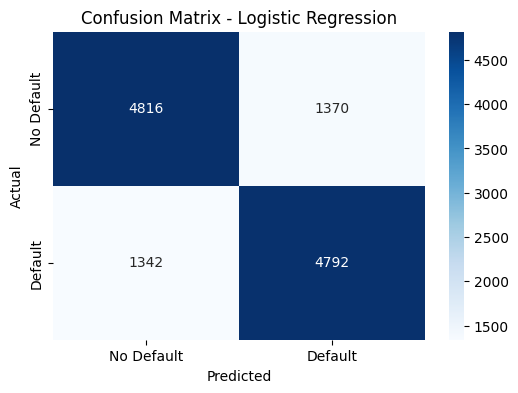

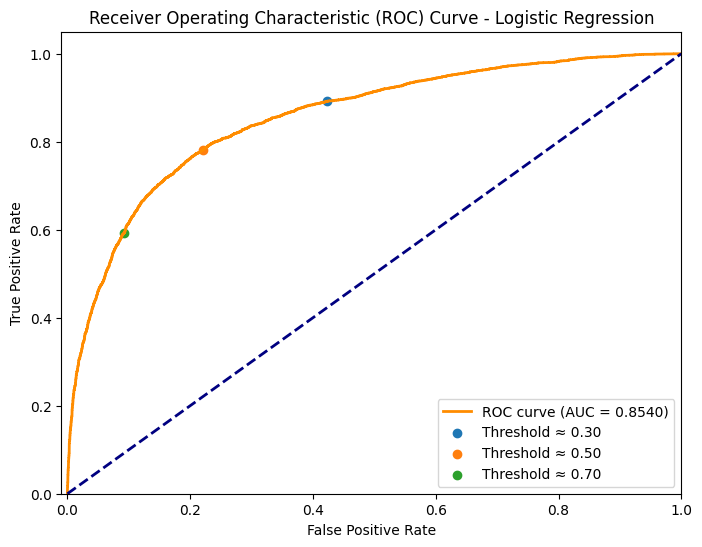

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:26:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6186
           1       0.98      0.93      0.96      6134

    accuracy                           0.96     12320
   macro avg       0.96      0.96      0.96     12320
weighted avg       0.96      0.96      0.96     12320



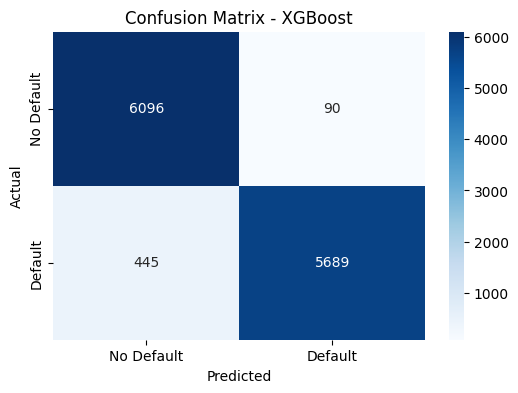

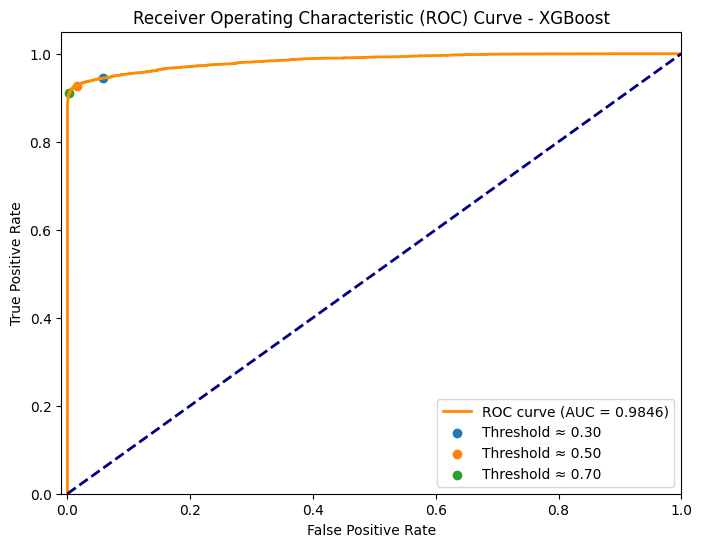


CatBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6186
           1       0.99      0.93      0.96      6134

    accuracy                           0.96     12320
   macro avg       0.96      0.96      0.96     12320
weighted avg       0.96      0.96      0.96     12320



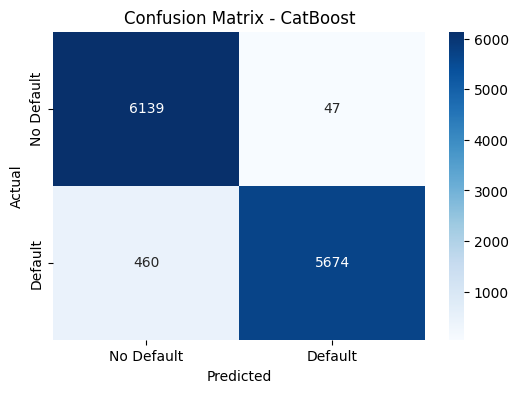

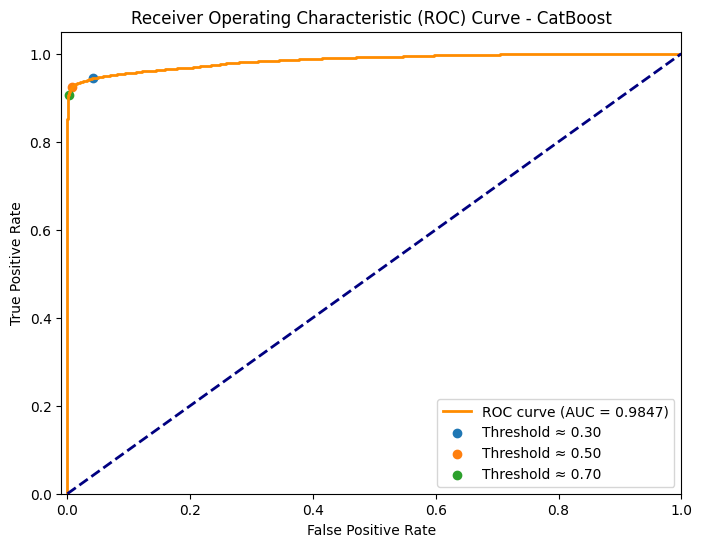


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6186
           1       0.90      0.92      0.91      6134

    accuracy                           0.91     12320
   macro avg       0.91      0.91      0.91     12320
weighted avg       0.91      0.91      0.91     12320



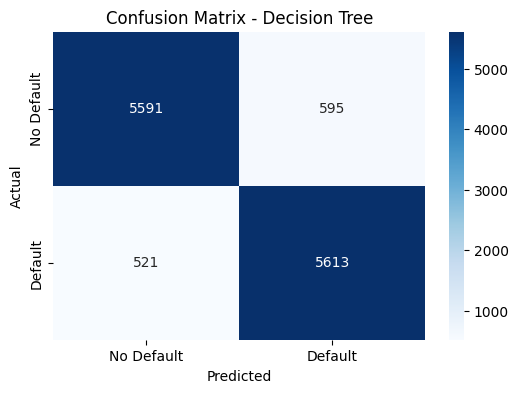

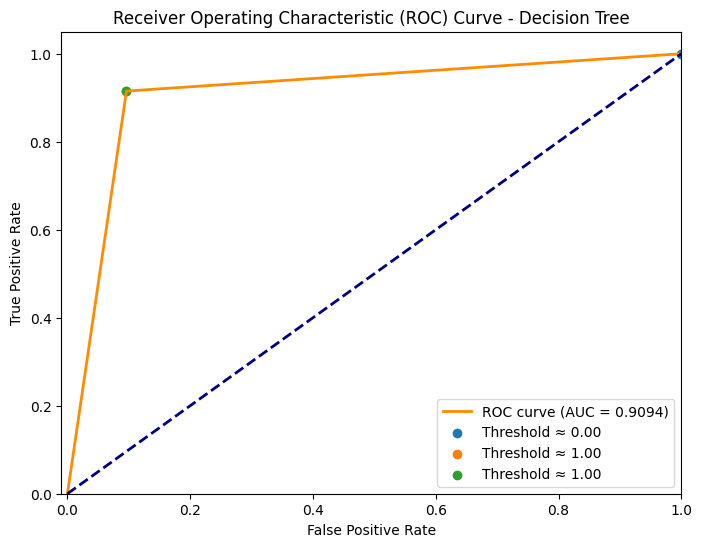


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6186
           1       0.98      0.92      0.95      6134

    accuracy                           0.95     12320
   macro avg       0.95      0.95      0.95     12320
weighted avg       0.95      0.95      0.95     12320



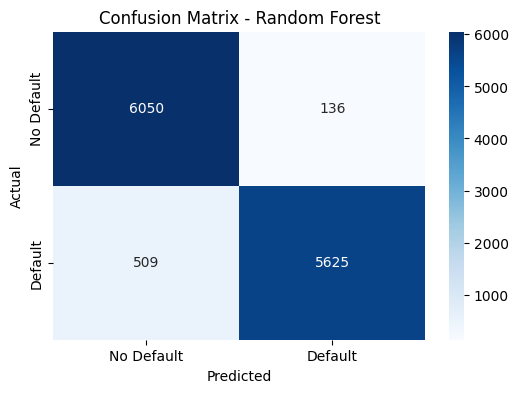

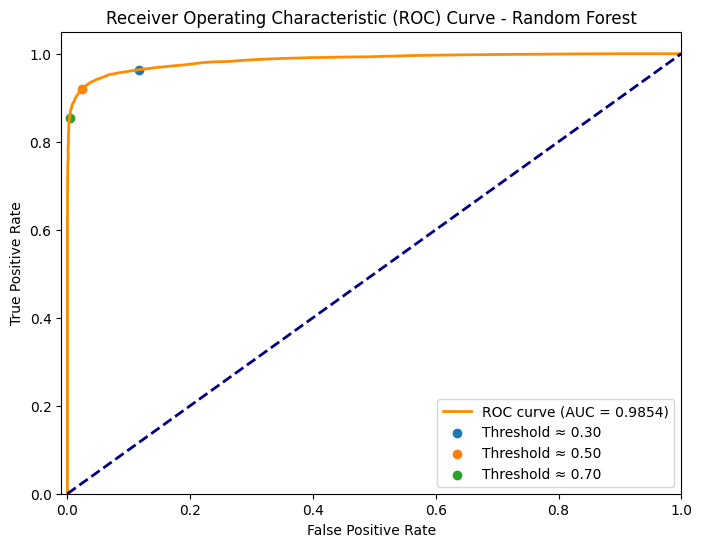

In [174]:
# Train and evaluate models
results = {}
# plt.figure(figsize=(8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Train AUC": roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        "Test AUC": roc_auc_score(y_test, y_pred_proba)

    }

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Call function to plot ROC curve
    plot_roc_curve(y_test, y_pred_proba, name)

In [175]:
# Convert results to DataFrame for easy visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                     Accuracy  Precision    Recall  F1-score       AUC  \
Logistic Regression  0.779870   0.777670  0.781219  0.779440  0.853972   
XGBoost              0.956575   0.984426  0.927454  0.955091  0.984550   
CatBoost             0.958847   0.991785  0.925008  0.957233  0.984698   
Decision Tree        0.909416   0.904156  0.915064  0.909577  0.909439   
Random Forest        0.947646   0.976393  0.917020  0.945776  0.985419   

                     Train Accuracy  Test Accuracy  Train AUC  Test AUC  
Logistic Regression        0.780317       0.779870   0.854302  0.853972  
XGBoost                    0.971648       0.956575   0.996694  0.984550  
CatBoost                   0.964899       0.958847   0.993674  0.984698  
Decision Tree              0.999965       0.909416   1.000000  0.909439  
Random Forest              0.999965       0.947646   1.000000  0.985419  


Based on the provided data, let's examine each model to assess if they are overfitting or underfitting:

Logistic Regression:

Observations: The train and test accuracy, as well as AUC values, are very close to each other. This indicates that the model generalizes well.
Conclusion: The model is well-fitted.
XGBoost:

Observations: There is a noticeable difference between train accuracy (97.16%) and test accuracy (95.66%), as well as train AUC (99.67%) and test AUC (98.45%).
Conclusion: This model is slightly overfitting, as indicated by higher performance on the training set compared to the test set.
CatBoost:

Observations: Similar to XGBoost, CatBoost shows a difference between train accuracy (96.49%) and test accuracy (95.88%), and train AUC (99.37%) versus test AUC (98.47%).
Conclusion: CatBoost is also slightly overfitting, although it is slightly better at generalizing than XGBoost given the smaller gaps in performance metrics.
Decision Tree:

Observations: A large discrepancy between train accuracy (99.99%) and test accuracy (90.94%), and a perfect train AUC (100%) compared to test AUC (90.94%).
Conclusion: This model is significantly overfitting. The decision tree is likely too complex, capturing noise in the training data that does not generalize to the test set.
Random Forest:

Observations: Another case where the train accuracy (99.99%) and AUC (100%) are much higher than the test accuracy (94.76%) and AUC (98.54%).
Conclusion: The Random Forest model is also overfitting, though not to the same extreme as the Decision Tree.
Overall, the Logistic Regression model shows the best generalization among the models. Both XGBoost and CatBoost exhibit slight overfitting, which might be mitigated by tuning hyperparameters or employing techniques like cross-validation. The Decision Tree and Random Forest models show considerable overfitting, suggesting a need for simplification or stronger regularization.